## Xfinity Report

The goal of this notebook is to generate all visualizations for Xfinity offers.

In [1]:
import os
import pandas as pd
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    speed_breakdown, 
    bucket_and_bin
)

In [2]:
# inputs
fn_xfinity = "../data/output/speed_price_xfinity.csv.gz"
fn_all_xfinity = "../data/open_address/processed/csv/city_of_boston-addresses-city.csv.gz"

# outputs
fn_speed = "../data/output/figs/fig1_xfinity.csv"
fn_fig3a = "../data/output/figs/fig3_income.csv"
fn_fig3b = "../data/output/figs/fig3_race.csv"
fn_fig3c = "../data/output/figs/fig3_redline.csv"

# notebook variable
ISP = 'Xfinity'

In [3]:
xfinity = pd.read_csv(fn_xfinity, compression='gzip')
len(xfinity)

5

In [4]:
all_xfinity = pd.read_csv(fn_all_xfinity, compression='gzip')
len(all_xfinity)

700

In [5]:
xfinity.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,fastest_speed_price,fn,redlining_grade,race_perc_non_white,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income
0,"31, Lewiston Street, Boston, MA, 02136",Boston,Boston,MA,42.266080,-71.112110,4,1.701787e+09,xfinity,400,...,130.0,../data/intermediary/isp/xfinity/boston/8.geoj...,NaN,0.819911,1.976762,4950.001661,3.0,-74525.0,0.886010,150823.0
1,"31, Lancaster Street, Boston, MA, 02114",Boston,Boston,MA,42.364435,-71.062312,2,1.701787e+09,xfinity,400,...,117.0,../data/intermediary/isp/xfinity/boston/2.geoj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"149, Charles Street, Boston, MA, 02114",Boston,Boston,MA,42.360479,-71.070570,3,1.701787e+09,xfinity,400,...,117.0,../data/intermediary/isp/xfinity/boston/10.geo...,D,0.096899,1.576057,22588.779155,3.0,-43952.0,0.945568,120250.0
3,"41, Capen Street, Boston, MA, 02124",Boston,Boston,MA,42.282700,-71.080580,4,1.701787e+09,xfinity,400,...,117.0,../data/intermediary/isp/xfinity/boston/7.geoj...,C,0.969828,0.392592,8892.551530,3.0,46344.0,0.901961,29954.0
4,"19, Everton Street, Boston, MA, 02121",Boston,Boston,MA,42.304910,-71.072680,3,1.701787e+09,xfinity,400,...,117.0,../data/intermediary/isp/xfinity/boston/9.geoj...,C,0.916580,0.344727,5095.724161,2.0,49996.0,0.775342,26302.0


In [6]:
print('Percent of households not served: ', str(round(len(xfinity)/len(all_xfinity)*100, 2))+'%')

Percent of households not served:  0.71%


In [7]:
xfinity = xfinity[xfinity.speed_down != 0]
len(xfinity)

5

In [8]:
xfinity = bucket_and_bin(xfinity)
xfinity.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,income_level,speed_down_bins,race_quantile,is_slow
0,"31, Lewiston Street, Boston, MA, 02136",Boston,Boston,MA,42.266080,-71.112110,4,1.701787e+09,xfinity,400,...,1.976762,4950.001661,3.0,-74525.0,0.886010,150823.0,Upper Income,Blazing (≥200),least white,0
1,"31, Lancaster Street, Boston, MA, 02114",Boston,Boston,MA,42.364435,-71.062312,2,1.701787e+09,xfinity,400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blazing (≥200),NaN,0
2,"149, Charles Street, Boston, MA, 02114",Boston,Boston,MA,42.360479,-71.070570,3,1.701787e+09,xfinity,400,...,1.576057,22588.779155,3.0,-43952.0,0.945568,120250.0,Upper Income,Blazing (≥200),most white,0
3,"41, Capen Street, Boston, MA, 02124",Boston,Boston,MA,42.282700,-71.080580,4,1.701787e+09,xfinity,400,...,0.392592,8892.551530,3.0,46344.0,0.901961,29954.0,Low,Blazing (≥200),least white,0
4,"19, Everton Street, Boston, MA, 02121",Boston,Boston,MA,42.304910,-71.072680,3,1.701787e+09,xfinity,400,...,0.344727,5095.724161,2.0,49996.0,0.775342,26302.0,Low,Blazing (≥200),least white,0


In [9]:
# who gets options?
xfinity[
    (xfinity["speed_down"] != xfinity["fastest_speed_down"])
    & (~xfinity["fastest_speed_down"].isnull())
]["speed_down"].value_counts(normalize=True)

speed_down
400    1.0
Name: proportion, dtype: float64

In [10]:
# make the above for each city:
city2speeds = pd.DataFrame()
for (city, state), _df in xfinity.groupby(["major_city", "state"]):
    row = _df.speed_down_bins.value_counts(normalize=True, sort=False).to_frame().T
    row.reset_index(drop=True, inplace=True)
    row["major_city"] = city.title()
    row["state"] = state
    city2speeds = pd.concat([city2speeds, row])
city2speeds.to_csv(fn_speed, index=False)

city2speeds

speed_down_bins,No service,Slow (<25 Mbps),Medium (25-99),Fast (100-199),Blazing (≥200),major_city,state
0,0.0,0.0,0.0,0.0,1.0,Boston,MA


In [28]:
variety = xfinity.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
homogenous_cities = variety[variety >= .95].index.get_level_values(0)
len(homogenous_cities)

1

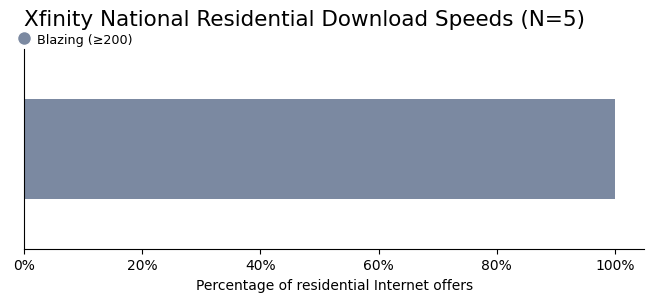

In [12]:
speed_breakdown(xfinity, isp=ISP)

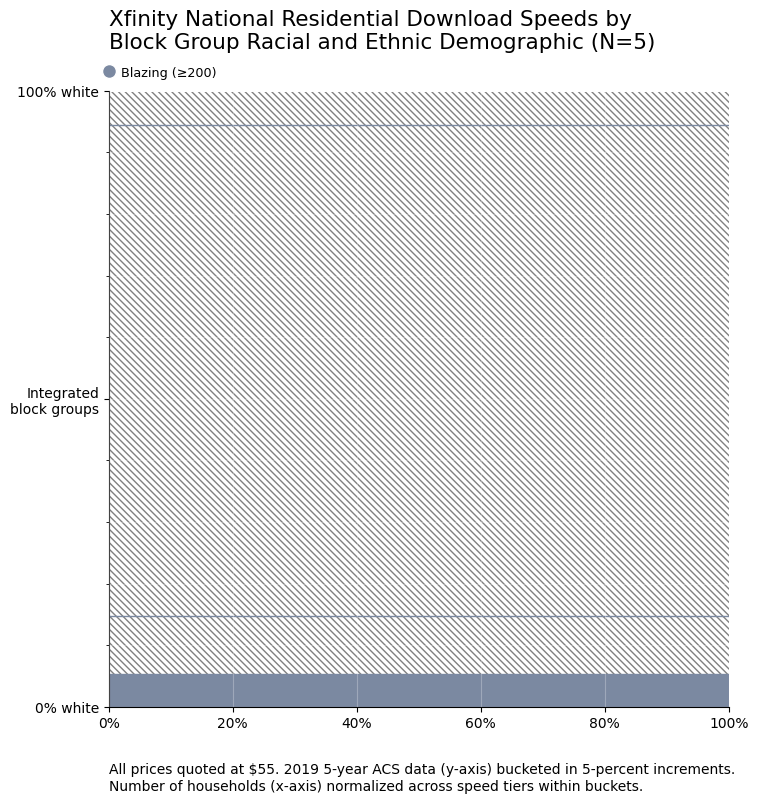

In [13]:
plot_race(xfinity, ISP)

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


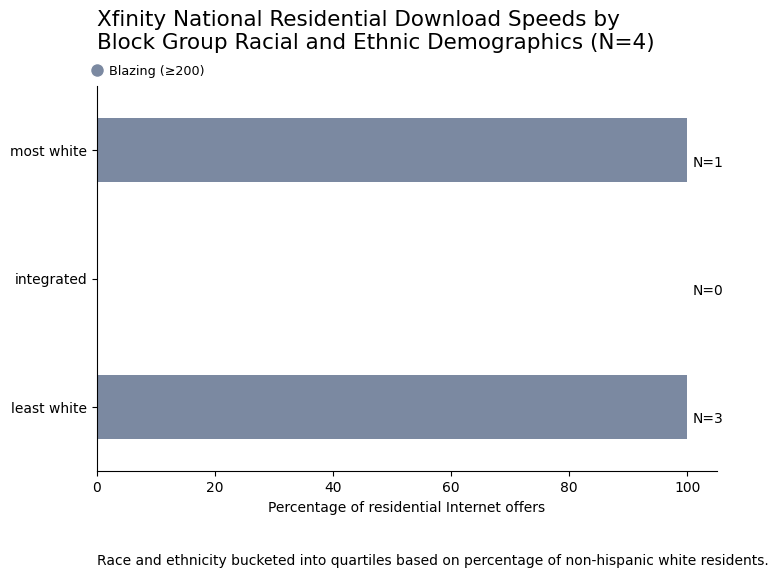

In [14]:
race(xfinity, ISP)

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_level")


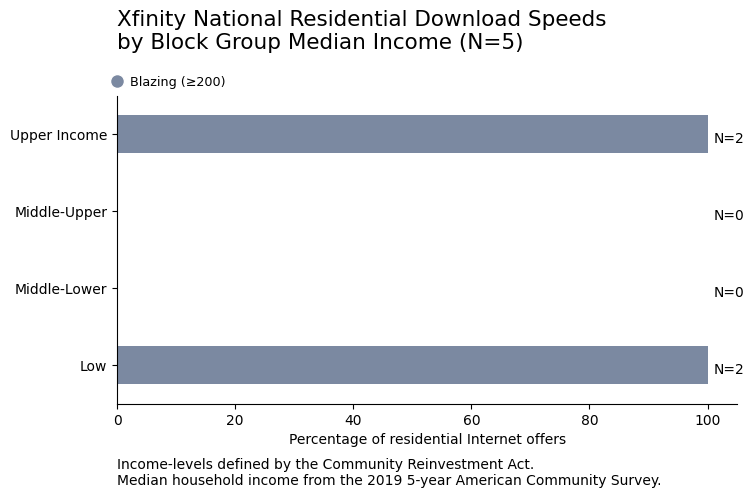

In [15]:
income(xfinity, ISP)

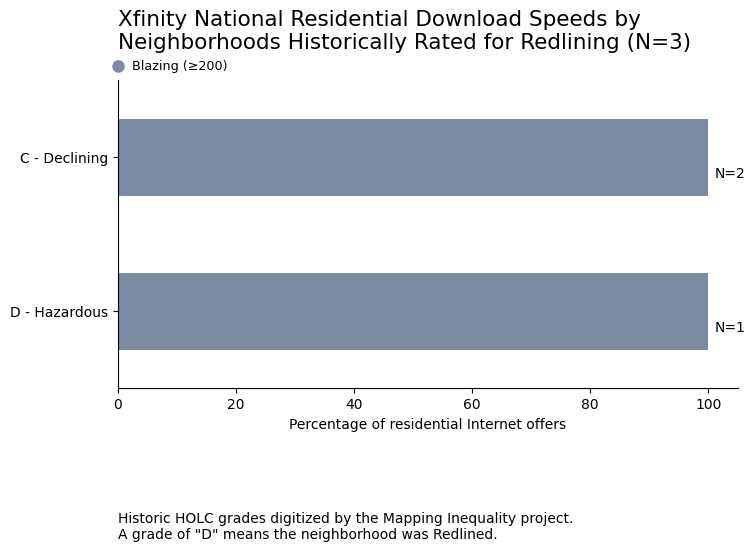

In [16]:
redlining(xfinity, ISP)

## City by City

Boston


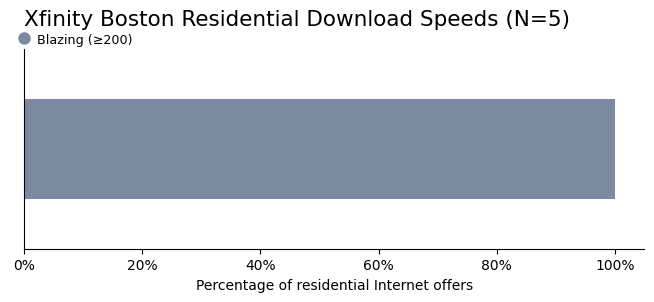

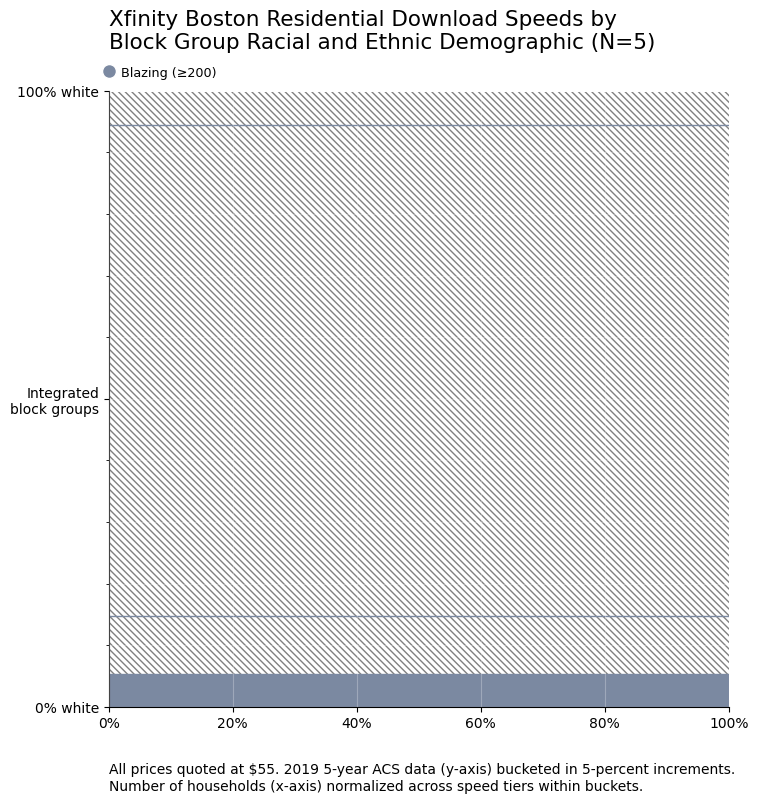

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


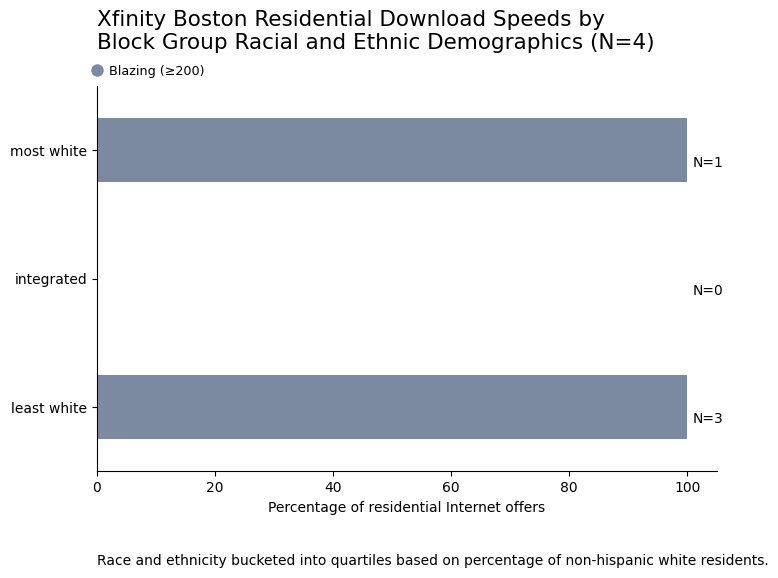

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_level")


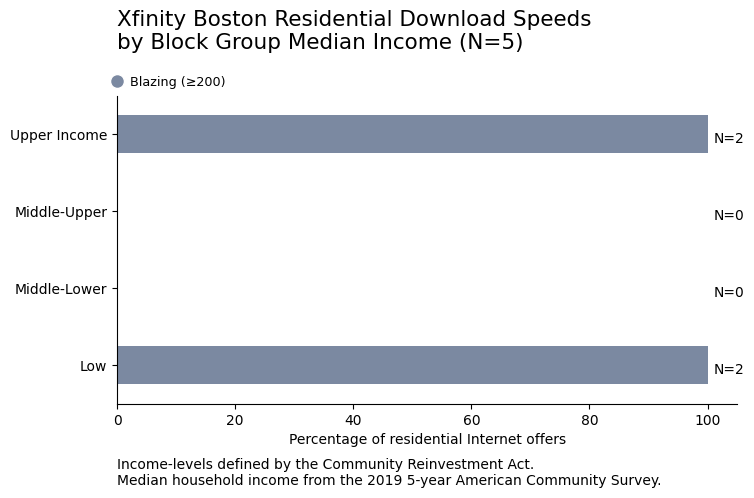

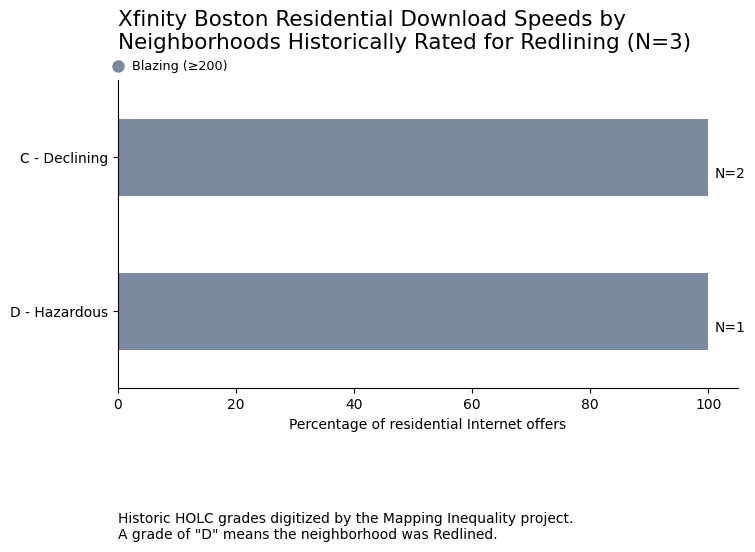

*******************************************************************************


In [17]:
for city, _df in xfinity.groupby("major_city"):
    print(city)
    _df = bucket_and_bin(_df, ISP)
    speed_breakdown(_df, ISP, location=city.title())
    plot_race(_df, ISP, location=city.title())
    race(_df, ISP, location=city.title())
    income(_df, ISP, location=city.title())
    redlining(_df, ISP, location=city.title())
    fn_out = f"../data/output/maps/xfinity/{city}_offers.csv"
    if not os.path.exists(fn_out):
        os.makedirs(os.path.dirname(fn_out), exist_ok=True)
        _df.to_csv(fn_out, index=False)
    print("*" * 79)

## One city's graphs as an example

In [18]:
from pandas.api.types import CategoricalDtype
from config import income_labels

In [19]:
# outputs
fn_fig3a = '../data/output/figs/fig3_income.csv'
fn_fig3b = '../data/output/figs/fig3_race.csv'
fn_fig3c = '../data/output/figs/fig3_redline.csv'

In [20]:
df_city = bucket_and_bin(xfinity[xfinity.major_city == "Boston"])

In [21]:
df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
     CategoricalDtype(income_labels, ordered=True)
).copy(deep=True)

to_plot = (df_city.groupby('income_level').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3a)

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_11116\1768510908.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('income_level').speed_down_bins


In [22]:
to_plot = (df_city.groupby('race_quantile').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3b)

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_11116\546127959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('race_quantile').speed_down_bins


In [23]:
to_plot = (df_city.groupby('redlining_grade').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3c)

In [24]:
# outputs
fn_fig_story_a = '../data/output/figs/story_income_{city}.csv'
fn_fig_story_b = '../data/output/figs/story_race_{city}.csv'
fn_fig_story_c = '../data/output/figs/story_redline_{city}.csv'

In [25]:
for city in ['Boston']:
    df_city = bucket_and_bin(xfinity[xfinity.major_city == city])
    df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
         CategoricalDtype(income_labels, ordered=True)
    ).copy(deep=True)

    to_plot = (df_city.groupby('income_level').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_a.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('race_quantile').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_b.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('redlining_grade').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_c.format(city=city.replace(' ', '_')))

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_11116\1808194628.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('income_level').speed_down_bins
C:\Users\J-Dog\AppData\Local\Temp\ipykernel_11116\1808194628.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('race_quantile').speed_down_bins


In [26]:
# how many addresses got 6 Mbps or less
len(xfinity[xfinity.speed_down <= 6])

0

In [27]:
# how many cities got 6 Mbps or less
xfinity[xfinity.speed_down <= 6].major_city.nunique()

0